# A Snapshot of Corruption, Well-Being, and Mortality Around the World

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#limitations">Limitations</a></li>
<li><a href="#conclusions">Conclusions</a></li>

<a id='intro'></a>
## Introduction

> I was intrigued by the Corruption Perception Index that I found on [Gapminder](https://www.gapminder.org/data/) and figured it would be a good opportunity to practice choropleth maps to visualize potential correlations with other variables. This project compares global and regional differences in the following metrics for 2017:
>
> **[Corruption Perception Index (CPI)](https://www.transparency.org/news/pressrelease/explanation_of_how_individual_country_scores_of_the_corruption_perceptions):** Downloadable csv from Gapminder. Draws on 13 surveys from independent institutions specialising in governance and business climate analysis covering expert assessments and views of businesspeople. The CPI generally defines corruption as "the misuse of public power for private benefit." A high CPI equates to less corruption.
>
> **[Human Development Index (HDI)](http://hdr.undp.org/en/data#):** Downloadable csv from UN Human Development Report. HDI is a three-dimensional index of health level, educational level, and standard of living. A high HDI equates to better quality of life.
>
> **[Child Mortality](https://www.gapminder.org/data/documentation/gd005/):** Downloadable csv from Gapminder. Defined as the death of children under five years of age per 1,000 live births.
>
> **[Total Fertility](https://www.gapminder.org/data/documentation/gd008/):** Downloadable csv from Gapminder. Defined as the number of children that would be born to a woman by summing age specific fertility rates over her lifetime.
>
> **Questions to consider:**
>
> - What does the distribution of data look like for each variable?
> - Is there a correlation between CPI and HDI?
> - Is there a correlation between child mortality and total fertility?
> - Which regions and countries rank highest and lowest in these categories?

### Perform Analysis and Visualization Imports

In [49]:
# Import analysis tools
import pandas as pd
import numpy as np
from functools import reduce

# Import visualization tools
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
import matplotlib.pyplot as plt

# Make Plotly and Matplotlib work within Jupyter Notebook
init_notebook_mode(connected=True)

<a id='wrangling'></a>
## Data Wrangling

### Perform Data Imports
The CPI dataset has ISO3 Country Codes that Plotly uses for generating choropleths. It also assigns countries to a region which will be helpful for regional comparisons.

In [50]:
# Define specific fields for each csv that I want to import:
fields_CPI = ['Country','ISO3','Region','CPI_2017']
fields_HDI = ['Country','2017']
fields_mort = ['geo','2017']
fields_per_woman = ['geo','2017']

# Read in csvs:
df_CPI = pd.read_csv('corruption_perception_index.csv', usecols = fields_CPI)
df_HDI = pd.read_csv('human_development_index.csv', usecols = fields_HDI)
df_mort = pd.read_csv('child_mortality_0_5_year_olds_dying_per_1000_born.csv', usecols = fields_mort)
df_fert = pd.read_csv('children_per_woman_total_fertility.csv', usecols = fields_per_woman)

# Rename columns:
df_CPI.rename(columns = {'CPI_2017':'CPI'}, inplace = True)
df_HDI.rename(columns = {'2017':'HDI'}, inplace = True)
df_mort.rename(columns = {'2017':'mort_rate', 'geo':'Country'}, inplace = True)
df_fert.rename(columns = {'2017':'fert_rate', 'geo':'Country'}, inplace = True)

### General Properties
I first looked at the data types and number of rows for the CPI, HDI, mortality, and fertility dataframes:

In [51]:
print(df_CPI.info())
print(df_HDI.info())
print(df_mort.info())
print(df_fert.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Data columns (total 4 columns):
Country    181 non-null object
ISO3       181 non-null object
Region     181 non-null object
CPI        180 non-null float64
dtypes: float64(1), object(3)
memory usage: 5.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189 entries, 0 to 188
Data columns (total 2 columns):
Country    189 non-null object
HDI        189 non-null float64
dtypes: float64(1), object(1)
memory usage: 3.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 2 columns):
Country      193 non-null object
mort_rate    183 non-null float64
dtypes: float64(1), object(1)
memory usage: 3.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 2 columns):
Country      184 non-null object
fert_rate    184 non-null float64
dtypes: float64(1), object(1)
memory usage: 3.0+ KB
None


Looks like the amount of countries for each dataset varies from 181 to 193. There are most likely omissions, repeats, or variablities in country spelling. In all dataframes, the country is recognized as an object and the metric is recognized as a float. ISO3 codes and regions are recognized as objects.

### Data Cleaning

I will merge the dataframes together based on country and see what countries are missing their ISO3 code. The [reduce](https://docs.python.org/3/library/functools.html) function is helpful for merging multiple dataframes together in one line of code.

In [52]:
# Merge based on Country
dataframes = [df_CPI, df_HDI, df_fert, df_mort]
df = reduce(lambda  left,right: pd.merge(left,right,on=['Country'],how='outer'), dataframes)
df.head(2)

,Country,ISO3,Region,CPI,HDI,fert_rate,mort_rate
0,New Zealand,NZL,AP,89.0,0.917,1.98,5.44
1,Denmark,DNK,WE/EU,88.0,0.929,1.75,4.00


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232 entries, 0 to 231
Data columns (total 7 columns):
Country      232 non-null object
ISO3         181 non-null object
Region       181 non-null object
CPI          180 non-null float64
HDI          189 non-null float64
fert_rate    184 non-null float64
mort_rate    183 non-null float64
dtypes: float64(4), object(3)
memory usage: 14.5+ KB


After the merge it looks like there are about 50 instances of missing ISO3 codes. Let's see what they are:

In [54]:
df[df['ISO3'].isnull()]

,Country,ISO3,Region,CPI,HDI,fert_rate,mort_rate
181,Andorra,NaN,NaN,NaN,0.858,NaN,NaN
182,Antigua and Barbuda,NaN,NaN,NaN,0.780,2.04,8.16
183,Belize,NaN,NaN,NaN,0.708,2.48,14.40
184,Bolivia (Plurinational State of),NaN,NaN,NaN,0.693,NaN,NaN
185,Congo (Democratic Republic of the),NaN,NaN,NaN,0.457,NaN,NaN
186,Czechia,NaN,NaN,NaN,0.888,NaN,NaN
187,Côte d'Ivoire,NaN,NaN,NaN,0.492,NaN,NaN
188,Eswatini (Kingdom of),NaN,NaN,NaN,0.588,NaN,NaN
189,Fiji,NaN,NaN,NaN,0.741,2.49,21.10
190,Guinea-Bissau,NaN,NaN,NaN,0.455,4.56,86.40


On first glance I see there are multiple Congo related rows. Let's see what these look like:

In [55]:
df[df['Country'].str.contains('Congo')]

,Country,ISO3,Region,CPI,HDI,fert_rate,mort_rate
161,Congo,COG,SSA,21.0,0.606,NaN,NaN
162,Democratic Republic of the Congo,COD,SSA,21.0,NaN,NaN,NaN
185,Congo (Democratic Republic of the),NaN,NaN,NaN,0.457,NaN,NaN
214,"Congo, Dem. Rep.",NaN,NaN,NaN,NaN,6.02,92.5
215,"Congo, Rep.",NaN,NaN,NaN,NaN,4.60,51.3


These rows include data for the Democratic Republic of the Congo (COD) and Congo (COG). Some form of regex expression could be made to filter these appropriately (as well as the other null ISO3 countries) but manual replacement will most likely be faster in this case. I will create a dictionary containing the missing ISO3 values found through a quick Google search:

In [56]:
ISO3_dict = {
    'Andorra':'AND',
    'Antigua and Barbuda':'ATG',
    'Belize':'BLZ',
    'Bolivia (Plurinational State of)':'BOL',
    'Congo (Democratic Republic of the)':'COD',
    'Czechia':'CZE',
    "Côte d'Ivoire":'CIV',
    'Eswatini (Kingdom of)':'SWZ',
    'Fiji':'FJI',
    'Guinea-Bissau':'GNB',
    'Hong Kong, China (SAR)':'HKG',
    'Iran (Islamic Republic of)':'IRN',
    'Kiribati':'KIR',
    'Korea (Republic of)':'KOR',
    "Lao People's Democratic Republic":'LAO',
    'Liechtenstein':'LIE',
    'Marshall Islands':'MHL',
    'Micronesia (Federated States of)':'FSM',
    'Micronesia, Fed. Sts.':'FSM',
    'Moldova (Republic of)':'MDA',
    'Palau':'PLW',
    'Palestine, State of':'PSE',
    'Russian Federation':'RUS',
    'Saint Kitts and Nevis':'KNA',
    'Samoa':'WSM',
    'Syrian Arab Republic':'SYR',
    'Tanzania (United Republic of)':'TZA',
    'The former Yugoslav Republic of Macedonia':'MKD',
    'Tonga':'TON',
    'United States':'USA',
    'Venezuela (Bolivarian Republic of)':'VEN',
    'Viet Nam':'VNM',
    'Brunei':'BRN',
    'Cape Verde':'CPV',
    'Congo, Dem. Rep.':'COD',
    'Congo, Rep.':'COG',
    "Cote d'Ivoire":'CIV',
    'Kyrgyz Republic':'KGZ',
    'Lao':'LAO',
    'Macedonia, FYR':'MKD',
    'North Korea':'PRK',
    'Palestine':'PSE',
    'Slovak Republic':'SVK',
    'South Korea':'KOR',
    'St. Lucia':'LCA',
    'St. Vincent and the Grenadines':'VCT',
    'Monaco':'MCO',
    'Nauru':'NRU',
    'San Marino':'SMR',
    'St. Kitts and Nevis':'KNA',
    'Tuvalu':'TUV'}

I can now [.fillna()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) by [mapping](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) the dictionary onto the appropriate column of the dataframe

In [57]:
df['ISO3'] = df['ISO3'].fillna(df['Country'].map(ISO3_dict))

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232 entries, 0 to 231
Data columns (total 7 columns):
Country      232 non-null object
ISO3         232 non-null object
Region       181 non-null object
CPI          180 non-null float64
HDI          189 non-null float64
fert_rate    184 non-null float64
mort_rate    183 non-null float64
dtypes: float64(4), object(3)
memory usage: 14.5+ KB


Now I have 232 Coutries and 232 ISO3 codes. I need to consolidate the data so that it's all on one row for each unique ISO3 code. [Groupby](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html) is perfect for this:

In [59]:
# Grouping by the ISO code and summing values will get all relevant 
# values in one row regardless of inconsistencies in country names
consol = df.groupby('ISO3').sum().reset_index()
# Replace 0 with null
consol.replace(0,np.nan,inplace=True)
consol.head(2)

,ISO3,CPI,HDI,fert_rate,mort_rate
0,AFG,15.0,0.498,4.48,68.2
1,AGO,19.0,0.581,5.62,83.1


In [60]:
consol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 5 columns):
ISO3         198 non-null object
CPI          180 non-null float64
HDI          189 non-null float64
fert_rate    184 non-null float64
mort_rate    183 non-null float64
dtypes: float64(4), object(1)
memory usage: 7.8+ KB


Afer consolidating, it looks like there are some ISO3 codes missing data from at least one of CPI, HDI, fert_rate, or mort_rate columns. Let's see what they are and determine if it's necessary to fill in these values from other sources:

In [61]:
consol.loc[consol.isnull().any(axis=1)]

,ISO3,CPI,HDI,fert_rate,mort_rate
3,AND,NaN,0.858,NaN,NaN
7,ATG,NaN,0.780,2.04,8.16
21,BLZ,NaN,0.708,2.48,14.40
43,CZE,57.0,0.888,1.56,NaN
46,DMA,57.0,0.715,NaN,NaN
57,FJI,NaN,0.741,2.49,21.10
59,FSM,NaN,0.627,3.10,33.30
72,HKG,77.0,0.933,NaN,NaN
92,KIR,NaN,0.612,3.61,53.60
93,KNA,NaN,0.778,NaN,NaN


There are 25 countries missing some sort of metric. Many of them are missing three or more which tells me the data is hard to find or irrelevant in these cases. For this reason, I chose to merge this dataframe back with the CPI dataframe to retain regional info:

In [62]:
# Merge ISO3 to country and region
df = pd.merge(consol,df_CPI[['ISO3','Country','Region']],on='ISO3', how='right')
df.head(2)

,ISO3,CPI,HDI,fert_rate,mort_rate,Country,Region
0,AFG,15.0,0.498,4.48,68.2,Afghanistan,AP
1,AGO,19.0,0.581,5.62,83.1,Angola,SSA


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181 entries, 0 to 180
Data columns (total 7 columns):
ISO3         181 non-null object
CPI          180 non-null float64
HDI          176 non-null float64
fert_rate    176 non-null float64
mort_rate    175 non-null float64
Country      181 non-null object
Region       181 non-null object
dtypes: float64(4), object(3)
memory usage: 11.3+ KB


In [64]:
# View any rows with null values
df.loc[df.isnull().any(axis=1)]

,ISO3,CPI,HDI,fert_rate,mort_rate,Country,Region
40,CZE,57.0,0.888,1.56,NaN,Czech Republic,WE/EU
43,DMA,57.0,0.715,NaN,NaN,Dominica,AME
67,HKG,77.0,0.933,NaN,NaN,Hong Kong,AP
88,KSV,39.0,NaN,NaN,NaN,Kosovo,ECA
131,PRI,NaN,NaN,NaN,NaN,Puerto Rico,AME
132,PRK,17.0,NaN,1.90,19.1,"Korea, North",AP
146,SOM,9.0,NaN,6.17,130.0,Somalia,SSA
166,TWN,63.0,NaN,NaN,NaN,Taiwan,AP


Of the 748 (181 rows mulitplied by the 4 metric columns) datapoints, 17 are missing. With 97.7% of data captured, I'm comfortable moving forward with visualizations to draw conclusions on this dataset.

<a id='eda'></a>
## Exploratory Data Analysis

### Individual Variables

Let's use Matplotlib's [.hist()](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) method to get a snapshot of each variable's data distribution:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020EB155EBE0>,
      dtype=object)

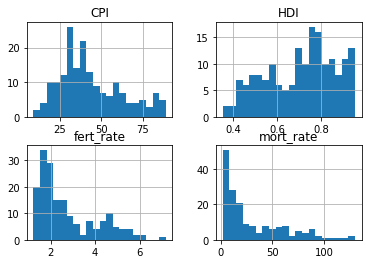

In [65]:
df.hist(bins=20)

Average CPI seems to be right around 40 with a slightly skewed right bell-shaped distribution. HDI looks to have slight bimodal behavior, potentially with two clumps of scores based on whether or not a country is developed or developing. Both Total Fertility and Mortality Rate are skewed right, meaning most countries have low fertility and mortality rates. We can easily see specific stats for each variable with the [.describe()](https://pandas.pydata.org/pandas-docs/version/0.22.0/generated/pandas.DataFrame.describe.html) pandas method:

In [66]:
df.describe()

,CPI,HDI,fert_rate,mort_rate
count,180.000000,176.000000,176.000000,175.000000
mean,43.072222,0.706875,2.752102,30.688229
std,19.051542,0.156529,1.333929,30.549764
min,9.000000,0.354000,1.230000,2.080000
25%,29.000000,0.586500,1.747500,7.595000
50%,38.500000,0.735500,2.250000,17.100000
75%,56.250000,0.826500,3.690000,49.600000
max,89.000000,0.953000,7.180000,130.000000


I go into more depth as to what countries are associated with the min and max values across variables in the [Regional Picture](#regional_picture) section of this report.

### Global Picture

Let's use Plotly's [choropleth](https://plot.ly/python/choropleth-maps/) feature coupled with a [dropdown](https://plot.ly/python/dropdowns/) to get a picture of how CPI, HDI, fertility rate, and mortality rate look across the world:

In [67]:
# Define variables to cycle through for creating traces
indicators = ['CPI','HDI','fert_rate','mort_rate']
# Populate data array with "indicators" traces
data = []
for value in indicators:
    trace = dict(
        type = 'choropleth',
        # Plotly uses ISO3 codes to populate locations on the choropleth
        locations = df['ISO3'],
        z = df[value],
        # On mouse hover, show the indicator value and country
        hoverinfo = 'z+text',
        text = df['Country'],
        # Chose a yellow to red colorscale from Plotly's library
        colorscale = 'YlOrRd',
        marker = dict(
            line = dict (
                color = 'black',
                width = 0.3)))
    data.append(trace)

# Define layout
layout = dict(
    title = 'Select option from dropdown to show corresponding choropleth:',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(type = 'robinson')))

# Define variables that will change aspects of the graph with each dropdown selection
labels = ['CPI','HDI','Total Fertility','Child Mortality']
titles = ['Corruption Perceptions Index<br>Source: <a href="https://www.transparency.org/\
            news/feature/corruption_perceptions_index_2017">Transparency.org</a>', # Backslash in url breaks up the string
          'Human Development Index<br>Source: <a href="http://hdr.undp.org/en/data#">UN Development Programme</a>',
          'Total Fertility<br>Source: <a href="https://www.gapminder.org/data/documentation/gd008/">Gapminder.org</a>',
          'Child Mortality<br>Source: <a href="https://www.gapminder.org/data/documentation/gd005/">Gapminder.org</a>']
# Change colorscale direction for Total Fertility and Child Mortality
colorscale_dir = [False, False, True, True]
colorbar_labels = ['CPI','HDI','Children<br>per Woman','0-5 y/o deaths<br>per 1000']
N = len(labels)

# Define dropdown selection behavior
updatemenus = list([
    dict(active=-1,buttons = list([
        dict(
            label = labels[k],
            method = 'update',
            # Define which traces are visible, reverse the colorscale if needed, change the title
            args = [{'visible':[True if k==j else False for j in range(N)],
                     'reversescale':colorscale_dir[k],
                     'colorbar':{'title':colorbar_labels[k]}},
                    {'title': titles[k]}],
                 ) for k in range(N)]))])

# Update layout with dropdown selection
layout['updatemenus'] = updatemenus

# Plot fig
fig = {'data':data, 'layout':layout}
iplot(fig)

> Based on the choropleths, my guess would be that correlations are strongest between Child Mortality and Total Fertility. Both these variables correlate pretty strongly with HDI, and the weakest correlation (albeit significant) is with CPI.

I will make a correlation matrix to visualize relationships:

In [69]:
# Create correlations array to populate heatmap
correlations = np.array(abs(df.corr()))
# Create heatmap using Plotly
data = [go.Heatmap(z = correlations, x = indicators, y = indicators,
                   zmin = 0, zmax = 1,
                  colorscale = 'Greens',
                  reversescale = True)]

layout = go.Layout(dict(
    title = 'Correlation Matrix'),
    height = 500, width = 500)

fig = {'data':data, 'layout':layout}
iplot(fig)

Based on the matrix, here are the correlation coefficients between each variable from largest to smallest:<br/>*Note:* I took the absolute value of the correlation coefficient to match the inverted colorscales in the choropleth for mortality and fertility. It makes sense that these would usually be negatively correlated with CPI and HDI.

> **Very Strong Correlation**<br/>
Mortality Rate & HDI&emsp;&emsp;&emsp;&emsp;&ensp;&nbsp;(0.88)<br/>
Mortality Rate & Fertility Rate&nbsp;&nbsp;&nbsp;(0.88)<br/>
Fertility Rate & HDI&emsp;&emsp;&emsp;&emsp;&emsp;&nbsp;(0.84)
> 
> **Strong Correlation**<br/>
HDI & CPI&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&nbsp;(0.74)
> 
> **Moderate Correlation**<br/>
Mortality Rate & CPI&emsp;&emsp;&emsp;&emsp;&ensp;&nbsp;(0.59)<br/>
Fertility Rate & CPI&emsp;&emsp;&emsp;&emsp;&ensp;&nbsp;&nbsp;&nbsp;(0.55)
> 
> The choropleth makes it easy to observe that developing countries throughout Africa and Southeast Asia are lagging behind most of the world in all categories. The correlation matrix confirms the hypothesis that was made from observing the choropleth.

<a id='regional_picture'></a>
### Regional Picture

A good way to compare indicators across regions is with a [boxplot](https://plot.ly/python/box-plots/). Similar to the choropleth plot, I will use Plotly and add a dropdown for indicator selection:

In [70]:
# Define variables to cycle through for creating traces
indicator = ['CPI','HDI','fert_rate','mort_rate']
# Populate list with "indicators" traces
data = []
for var in indicator:
    # Populate list with regional traces
    indicator_data = []
    for region in df['Region'].unique():
        reg = df[df['Region'] == region]
        trace = go.Box(
            y = reg[var],
            name = region,
            text = df[df['Region'] == region]['Country'],
            boxpoints = 'all',
            jitter = 0.6,
            pointpos = 0)
        indicator_data.append(trace)
    data.append(indicator_data)
# Combine the data  for each indicator
alldata = data[0] + data[1] + data[2] + data[3]

# Define dropdown selection behavior
updatemenus = list([
    dict(active=-1, buttons=list([
        # Define which traces are visible for each indicator, change the title and yaxis title.
        # 4 indicators for 6 regions = 24 traces. {'visible': [True]*6+[False]*18} means the 
        # first 6 traces (the CPI traces) are visible and remaining 18 are not.
        dict(label = 'CPI',
             method = 'update',
             args = [{'visible': [True]*6+[False]*18},
                     {'title':'CPI by Region',
                     'yaxis':{'title':'CPI'}}]),
        dict(label = 'HDI',
             method = 'update',
             args = [{'visible': [False]*6+[True]*6+[False]*12},
                     {'title':'HDI by Region',
                     'yaxis':{'title':'HDI'}}]),
        dict(label = 'Total Fertility',
             method = 'update',
             args = [{'visible': [False]*12+[True]*6+[False]*6},
                     {'title':'Total Fertility by Region',
                     'yaxis':{'title':'Children per Woman'}}]),
        dict(label = 'Child Mortality',
             method = 'update',
             args = [{'visible': [False]*18+[True]*6},
                     {'title':'Child Mortality by Region',
                     'yaxis':{'title':'0-5 y/o deaths per 1000'}}])]))])

# Define layout
layout = go.Layout(
        showlegend = False,
        xaxis = dict(title = 'Region'),
        yaxis = dict(nticks = 10),
        # Update layout with dropdown selection
        updatemenus = updatemenus)

# Plot fig
fig = {'data':alldata,'layout':layout}
iplot(fig)

AP = Asia-Pacific<br/>
SSA = Sub-Saharan Africa<br/>
ECA = Eastern Europe & Central Asian<br/>
MENA = Middle East & North Africa<br/>
AME = The Americas<br/>
WE/EU = Western Europe/European Union

> If it wasn't obvious enough with the choropleth, Sub-Saharan Africa appears to be behind the rest of the world when it comes to lowering mortality and fertility rates and increasing CPI and HDI.
> 
> In fact, Sub-Saharan Africa's median HDI (0.52) is lower than every other coutry in the world except for Haiti, Afghanistan, and Yemen. Its median total fertility (4.56) is higher than every country save Timor-Leste and its median chid mortality (64.4) is higher than every country except for Haiti and Pakistan.
> 
> Somalia is the biggest loser when it comes to CPI and child mortality, and Niger's highest total fertility probably contributes to its world-worst HDI. On a more positive note, New Zealand leads the world in CPI (89) and Norway leads in HDI (0.95). Portugal has the fewest children per woman (1.24) and Finland has the lowest child mortality rate (2.08).
> 
> An additional observation that can be taken from the regional boxplot is that the distribution of child mortality, total fertility, and HDI data is more compact in regions with developed countries (The Americas, particularly North, and Western Europe) than developing countries prevalent in the Middle East, Asia-Pacific, and Africa. However, there doesn't seem to be a significant pattern in the size of the distribution for CPI, which could be why it doesn't correlate as closely with the other indicators. This means that although developing regions are more prone to corruption, developed nations can still struggle to fight corruption such as Russia, China, and Italy.

<a id='limitations'></a>
## Limitations

> This project summarizes a snapshot of corruption, well-being, and mortality around the world for a single year. An additional step would be to look at these variables over a period of time. The initial goal was to add a time element, but missing data proved to be the biggest obstacle. Gapminder has CPI data going back to only 2012, and although the other variables have older data gathered, there are more missing values. This may be attributed to changing data collection methods or even changing countries over time. Compiling data from additional sources would be an option for populating missing values or for looking at correlations with additional variables such as education or GDP. Regardless, variabilty in country names proved to be a time-consuming issue to resolve, and the dictionary method that was used to match ISO3 codes would not be an efficient way to populate missing values for a larger dataset. The next iteration of this project would include a function that uses regex to group similar country spellings.

<a id='conclusions'></a>
## Conclusions

> After reading in csvs from Gapminder and the UN Human Development Report for 2017, a dataframe with CPI, HDI, total fertility, and child mortality was created from merging columns on shared country names. The most labor intensive data cleaning step was consolidating multiple country spellings under the same ISO3 code. After combining appropriate rows and merging with the CPI dataframe that contains regional info, only 2.3% of values were missing.
>
> Once the dataframe was cleaned up, histograms were created to get an idea of data distribution for each variable. Total Fertility and Child Mortality were skewed strongly right, CPI was a slightly skewed right bell-shaped curve, and HDI appeared to be bimodal. Additional minimum and maximum observations were made later in the Regional Picture section by interacting with Plotly's boxplot. After gaining some insights into the individual data distributions, a choropleth was created with Plotly. This showed that developing countries lag behind deveoped countries in controlling total fertility, child mortality, and HDI. Global CPI scores aren't very good across the globe, and the choropleth made it easy to see developed countries that score relatively lower. A correlation matrix confirmed what was shown in the choropleth, where strong correlations exist between all variables except for mortality or fertility rate and CPI.
>
> A boxplot was created with Plotly to compare variables across regions. This was helpful for visualizing ranges of the distributions. Developed regions have tighter distributions than developing regions across all variables expect for CPI. The boxplots also showed that the whole Sub-Saharan Africa region struggles more on average than nearly all other individual countries with HDI, total fertility, and child mortatlity. This matches the heavily skewed characteristics of the fertility and mortality histograms, where the Sub-Saharan Africa region accounts for most of the data on the right side of thefertility and mortality histogram peaks.
>
> In conclusion, a country's level of corruption correlates strongly with its well-being (HDI), but not as much with its fertility or mortality. Mortality and fertility correlate very strongly with each other as well as HDI, meaning well-being is better in countries where less children are born to each woman or die before the age of five.